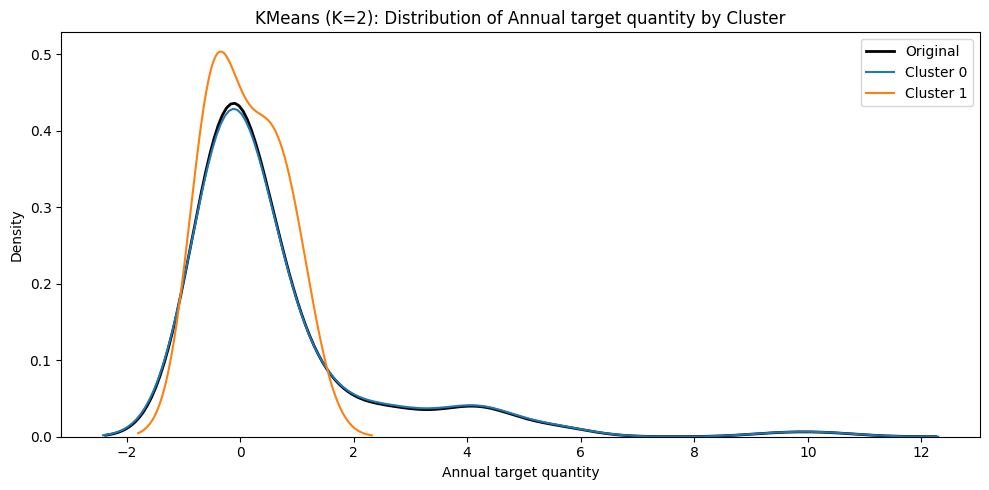

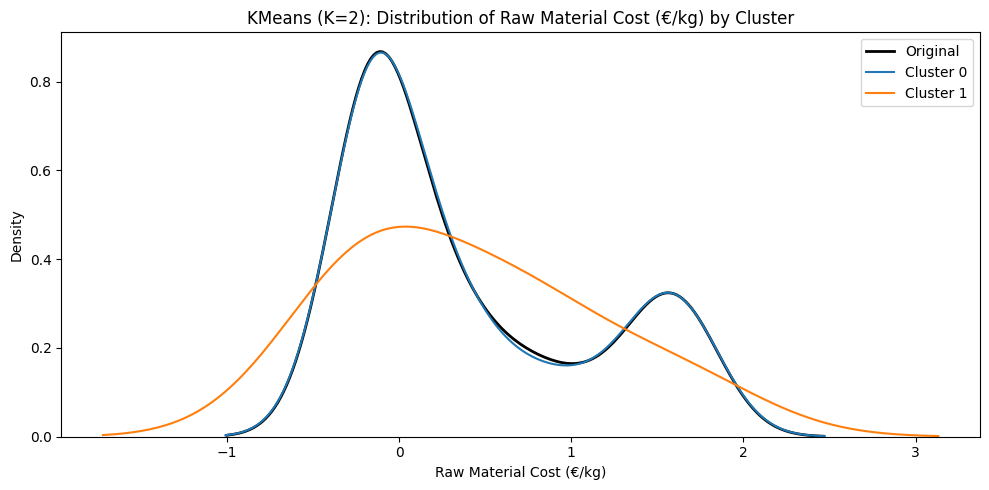

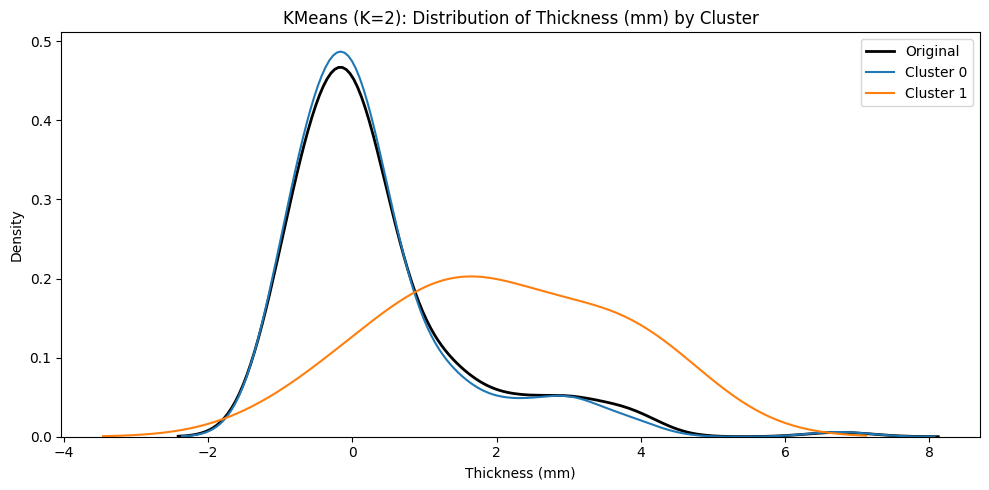

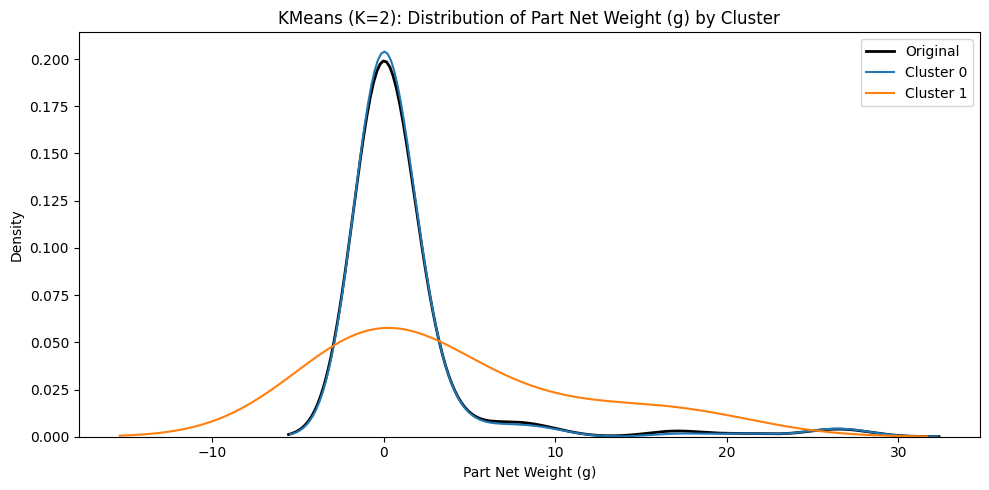

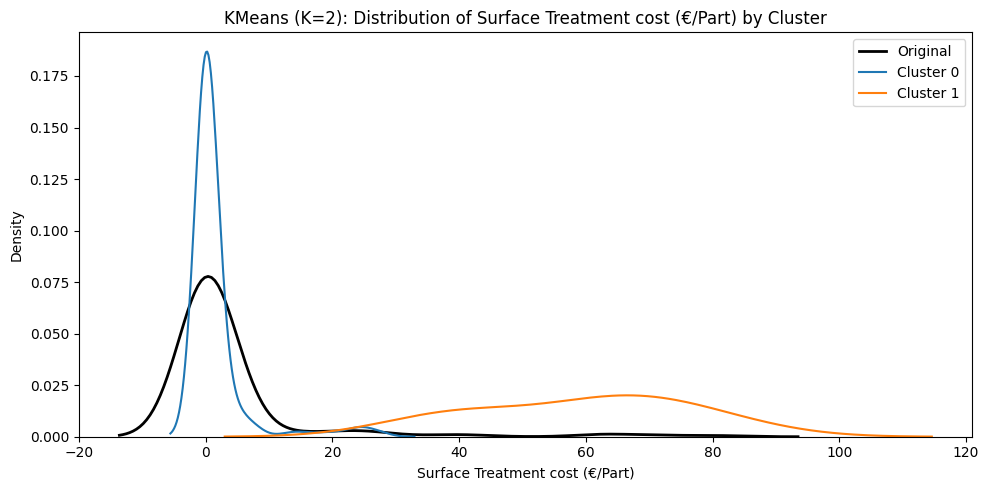

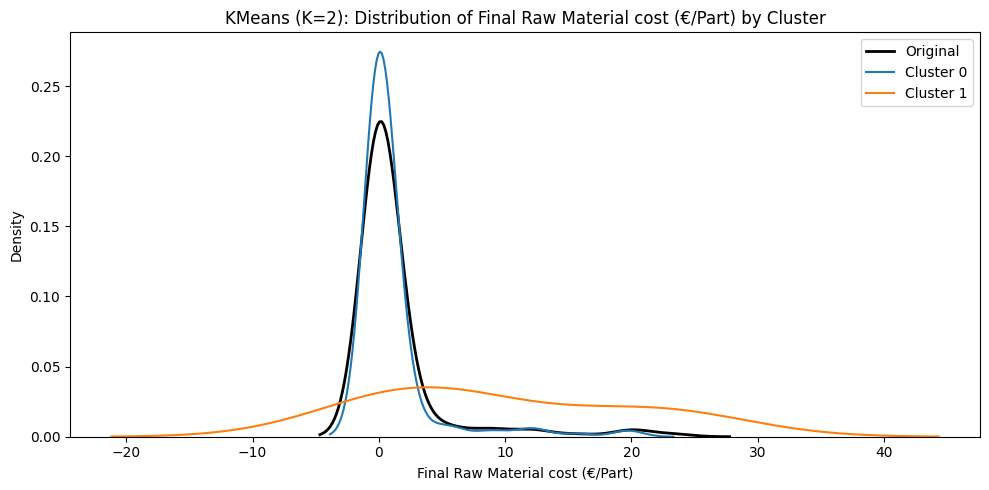

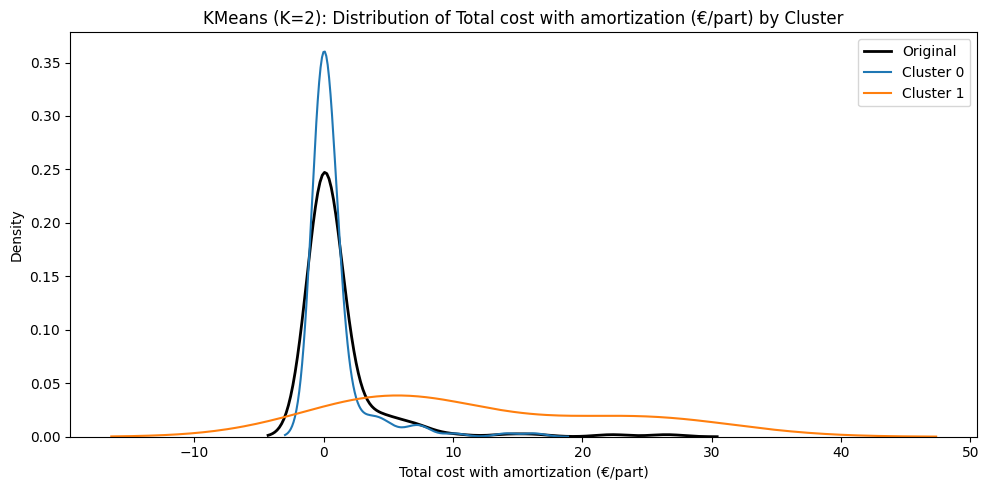

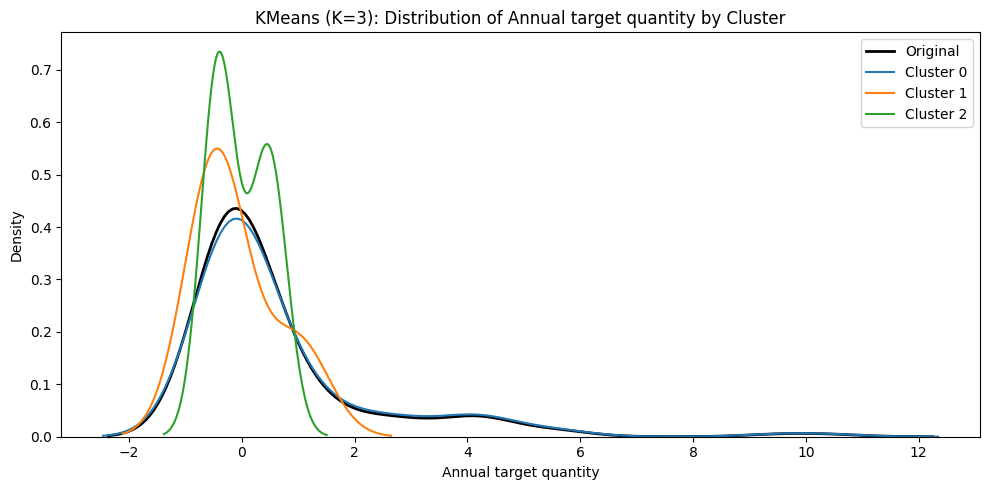

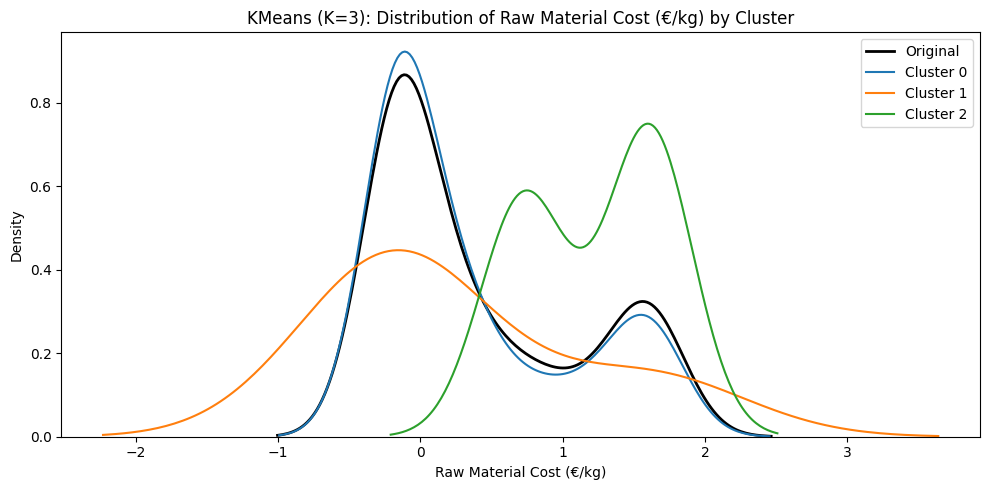

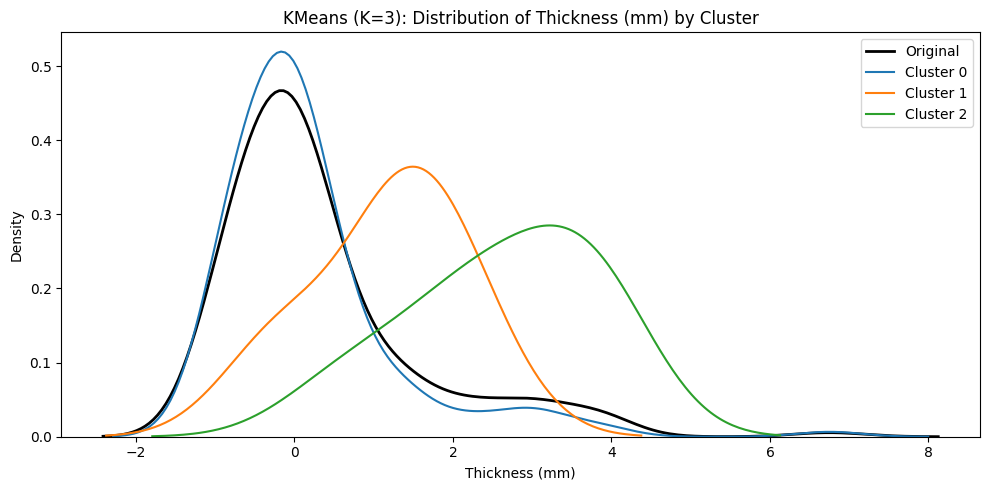

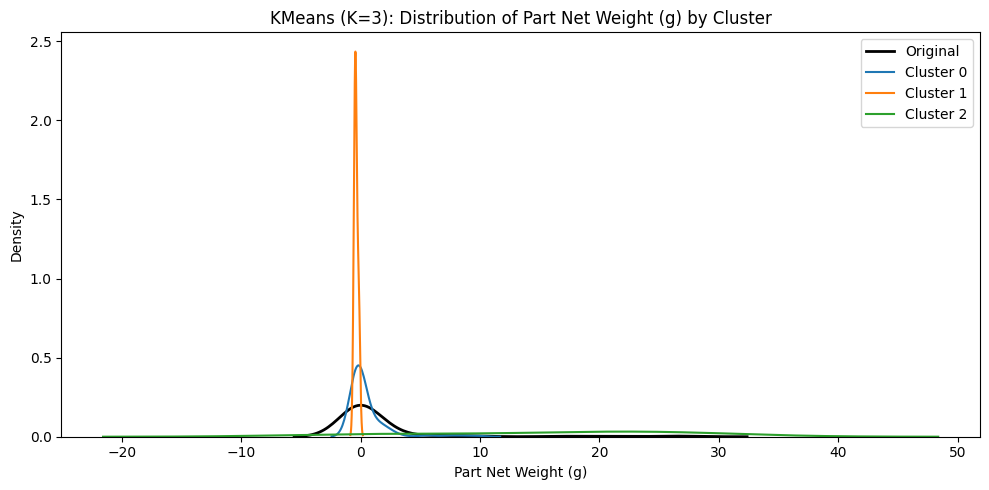

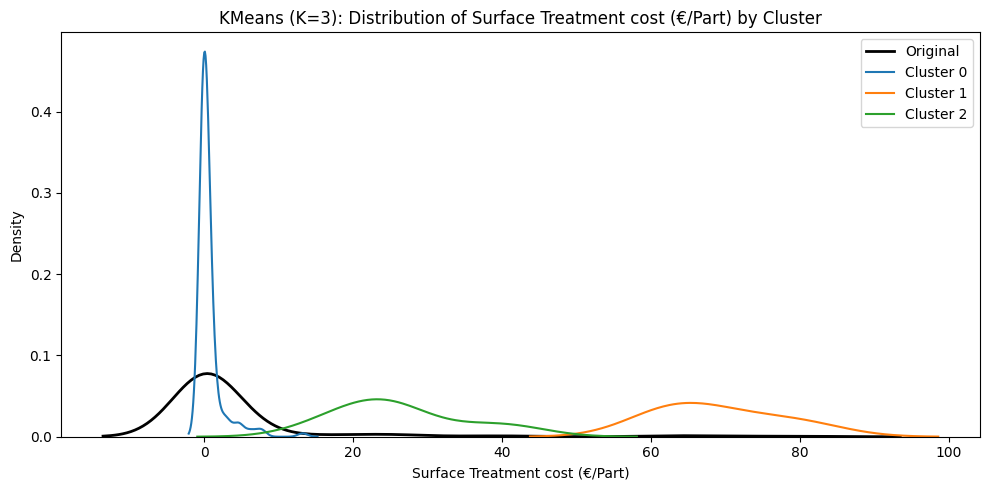

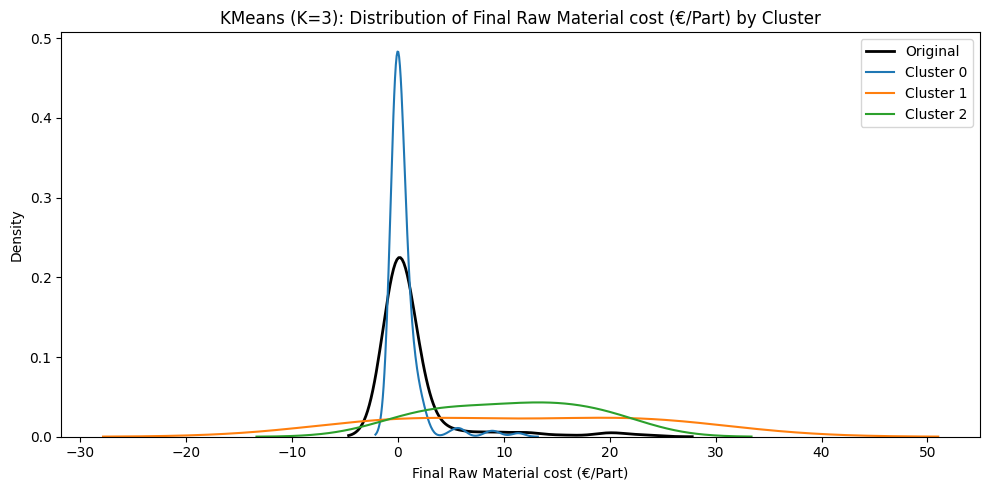

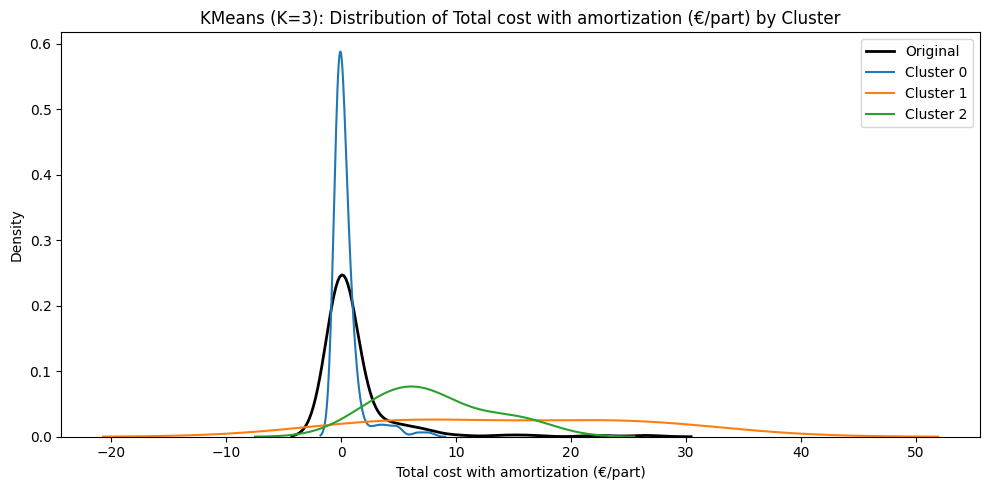

In [7]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, MeanShift
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity',
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Total cost with amortization (€/part)'
]

# Drop rows with missing values in numerical columns
df = df.dropna(subset=num_cols).reset_index(drop=True)

# 2. Apply RobustScaler
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

# 3. Clustering
X = df_scaled[num_cols].values

# KMeans with K=2
kmeans2 = KMeans(n_clusters=2, random_state=0)
df_scaled['KMeans_2'] = kmeans2.fit_predict(X)

# KMeans with K=3
kmeans3 = KMeans(n_clusters=3, random_state=0)
df_scaled['KMeans_3'] = kmeans3.fit_predict(X)


# 4. Plot distributions
def plot_distributions(df, num_cols, cluster_col, algo_name):
    for col in num_cols:
        plt.figure(figsize=(10, 5))
        # Plot original distribution (all data)
        sns.kdeplot(df[col], label='Original', color='black', lw=2)
        # Plot each cluster's distribution
        for cluster in sorted(df[cluster_col].unique()):
            sns.kdeplot(df[df[cluster_col] == cluster][col], label=f'Cluster {cluster}')
        plt.title(f'{algo_name}: Distribution of {col} by Cluster')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Plot for KMeans_2
plot_distributions(df_scaled, num_cols, 'KMeans_2', 'KMeans (K=2)')

# Plot for KMeans_3
plot_distributions(df_scaled, num_cols, 'KMeans_3', 'KMeans (K=3)')

# Optional: Save clustered DataFrame
df_scaled.to_excel('Clustered_Data.xlsx', index=False)


In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')  # Ensure correct file path
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = ['Annual target quantity', 'Raw Material Cost (€/kg)', 
           'Thickness (mm)', 'Part Net Weight (g)', 
           'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)']
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[num_cols])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Model setup
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5),
    'SVM': SVR(kernel='linear', C=1.0),
    'DecisionTree': DecisionTreeRegressor(max_depth=5),
    'CatBoost': CatBoostRegressor(iterations=100, depth=3, silent=True)
}

results = []

# Evaluate models per cluster
for cluster in [0, 1]:
    cluster_df = df[df['Cluster'] == cluster]
    X = cluster_df.drop(columns=[TARGET, 'Cluster'])
    y = cluster_df[TARGET]
    
    if len(y) < 5:  # Skip small clusters
        continue
        
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    for model_name, model in models.items():
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        # Calculate metrics
        mape = mean_absolute_percentage_error(y_test, y_pred)
        within_10 = np.mean(np.abs((y_test - y_pred)/y_test) <= 0.1)
        
        results.append({
            'Cluster': cluster,
            'Model': model_name,
            'MAPE': mape,
            'Within_10%': within_10,
            'Samples': len(y)
        })

# Create results dataframe
results_df = pd.DataFrame(results)
print(results_df)


    Cluster         Model       MAPE  Within_10%  Samples
0         0         Ridge   2.491497    0.400000       23
1         0         Lasso   4.642090    0.200000       23
2         0  RandomForest   1.858763    0.400000       23
3         0           SVM  11.140621    0.000000       23
4         0  DecisionTree   0.740753    0.400000       23
5         0      CatBoost   1.679590    0.400000       23
6         1         Ridge   1.270931    0.142857      136
7         1         Lasso   3.080317    0.107143      136
8         1  RandomForest   1.717387    0.214286      136
9         1           SVM   2.487123    0.035714      136
10        1  DecisionTree   2.235617    0.214286      136
11        1      CatBoost   0.866016    0.250000      136


In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

# Custom mean encoder transformer
class MeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
        self.encodings = {}
        
    def fit(self, X, y):
        for col in self.cat_cols:
            self.encodings[col] = y.groupby(X[col]).mean().to_dict()
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        for col in self.cat_cols:
            X_encoded[col] = X_encoded[col].map(self.encodings[col])
            # Handle unseen categories with global mean
            if X_encoded[col].isnull().any():
                global_mean = np.mean(list(self.encodings[col].values()))
                X_encoded[col].fillna(global_mean, inplace=True)
        return X_encoded

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

# Define columns
num_cols = ['Annual target quantity', 'Raw Material Cost (€/kg)', 
            'Thickness (mm)', 'Part Net Weight (g)', 
            'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)']
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

# Handle missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[num_cols])

# Model definitions
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'SVM': SVR(kernel='linear', C=1.0),
    'DecisionTree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, depth=3, silent=True, random_seed=42)
}

results = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for cluster in [0, 1]:
    cluster_df = df[df['Cluster'] == cluster]
    X = cluster_df.drop(columns=[TARGET, 'Cluster'])
    y = cluster_df[TARGET]

    if len(y) < 5:
        print(f"Skipping cluster {cluster} - insufficient samples")
        continue

    for model_name, model in models.items():
        fold_results = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Preprocessing setup
            if model_name == 'CatBoost':
                preprocessor = ColumnTransformer([
                    ('num', RobustScaler(), num_cols),
                    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
                ])
            else:
                # Mean encoding + scaling pipeline
                preprocessor = Pipeline([
                    ('mean_encoder', MeanEncoder(cat_cols)),
                    ('scaler', RobustScaler())
                ])

            pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            try:
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
            except Exception as e:
                print(f"Error in {model_name} (Cluster {cluster}, Fold {fold}): {str(e)[:100]}")
                continue

            # Calculate metrics
            metrics = {
                'Cluster': cluster,
                'Model': model_name,
                'Fold': fold,
                'R2': r2_score(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'MAPE': mean_absolute_percentage_error(y_test, y_pred),
                'Within_10%': np.mean(np.abs((y_test - y_pred) / y_test) <= 0.10) * 100,
                'Samples': len(y_test)
            }
            results.append(metrics)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Configure display settings
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 20)

# Print results by cluster
for cluster in sorted(results_df['Cluster'].unique()):
    cluster_results = results_df[results_df['Cluster'] == cluster]
    
    # Calculate summary statistics
    summary = cluster_results.groupby('Model').agg({
        'R2': ['mean', 'std'],
        'RMSE': ['mean', 'std'],
        'MAE': ['mean', 'std'],
        'MAPE': ['mean', 'std'],
        'Within_10%': ['mean', 'std'],
        'Samples': 'sum'
    })
    
    # Format metrics
    formatted_summary = pd.DataFrame()
    for metric in ['R2', 'RMSE', 'MAE', 'MAPE']:
        formatted_summary[metric] = (
            summary[metric]['mean'].round(3).astype(str) + 
            ' ± ' + 
            summary[metric]['std'].round(3).astype(str)
        )
    
    # Format percentage metrics
    formatted_summary['Within_10%'] = (
        summary['Within_10%']['mean'].round(1).astype(str) + 
        '% ± ' + 
        summary['Within_10%']['std'].round(1).astype(str) + '%'
    )
    
    formatted_summary['Samples'] = summary['Samples']['sum']
    
    print(f"\n{'='*40}")
    print(f"Cluster {cluster} Performance Metrics")
    print(f"{'='*40}")
    print(formatted_summary.reset_index().to_string(index=False, justify='center'))
    print(f"\nKey Metrics:")
    print("- R2: Higher is better (perfect = 1)")
    print("- RMSE/MAE: Lower is better")
    print("- MAPE: Percentage error (lower better)")
    print("- Within_10%: Percentage of predictions within 10% of actual")
    print(f"{'='*40}\n")

# Residuals visualization
residuals_df = results_df.explode('Residuals') if 'Residuals' in results_df else pd.DataFrame()
if not residuals_df.empty:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='Model', y='Residual', hue='Cluster', data=residuals_df)
    plt.title('Residual Distribution by Model and Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No residuals data to visualize")



Cluster 0 Performance Metrics
     Model              R2             RMSE          MAE           MAPE       Within_10%   Samples
        CatBoost    0.045 ± 0.395 0.032 ± 0.027  0.02 ± 0.015 0.712 ± 0.422 31.0% ± 16.2%    23   
    DecisionTree   -0.503 ± 0.693  0.04 ± 0.034 0.026 ± 0.022 0.716 ± 0.214 31.0% ± 16.2%    23   
           Lasso    -1.069 ± 1.13 0.042 ± 0.026  0.03 ± 0.014 1.774 ± 1.481  22.0% ± 8.4%    23   
LinearRegression   -1.001 ± 1.079 0.041 ± 0.026 0.027 ± 0.014 1.485 ± 1.596 22.6% ± 17.5%    23   
    RandomForest   -0.304 ± 0.162  0.037 ± 0.03 0.025 ± 0.017  1.19 ± 0.752 31.5% ± 23.0%    23   
           Ridge   -0.374 ± 0.928  0.033 ± 0.02 0.022 ± 0.011  1.275 ± 1.33 26.8% ± 15.3%    23   
             SVM -12.163 ± 10.753 0.076 ± 0.007 0.065 ± 0.019 4.194 ± 3.709   4.2% ± 7.2%    23   

Key Metrics:
- R2: Higher is better (perfect = 1)
- RMSE/MAE: Lower is better
- MAPE: Percentage error (lower better)
- Within_10%: Percentage of predictions within 10% of actu

In [25]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

# Custom mean encoder transformer
class MeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
        self.encodings = {}
        
    def fit(self, X, y):
        for col in self.cat_cols:
            self.encodings[col] = y.groupby(X[col]).mean().to_dict()
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        for col in self.cat_cols:
            X_encoded[col] = X_encoded[col].map(self.encodings[col])
            # Handle unseen categories with global mean
            if X_encoded[col].isnull().any():
                global_mean = np.mean(list(self.encodings[col].values()))
                X_encoded[col].fillna(global_mean, inplace=True)
        return X_encoded

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

# Define columns
num_cols = ['Annual target quantity', 'Raw Material Cost (€/kg)', 
            'Thickness (mm)', 'Part Net Weight (g)', 
            'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)']
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

# Handle missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[num_cols])

# Model definitions
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'SVM': SVR(kernel='linear', C=1.0),
    'DecisionTree': DecisionTreeRegressor(max_depth=6, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=700, depth=6, silent=True, random_seed=42, subsample=0.7, learning_rate= 0.02, min_data_in_leaf= 30, grow_policy='Depthwise') 
 
}

results = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for cluster in [0, 1]:
    cluster_df = df[df['Cluster'] == cluster]
    X = cluster_df.drop(columns=[TARGET, 'Cluster'])
    y = cluster_df[TARGET]

    if len(y) < 5:
        print(f"Skipping cluster {cluster} - insufficient samples")
        continue

    for model_name, model in models.items():
        fold_results = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Preprocessing setup
            if model_name == 'CatBoost':
                preprocessor = ColumnTransformer([
                    ('num', RobustScaler(), num_cols),
                    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
                ])
            else:
                # Mean encoding + scaling pipeline
                preprocessor = Pipeline([
                    ('mean_encoder', MeanEncoder(cat_cols)),
                    ('scaler', RobustScaler())
                ])

            pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            try:
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
            except Exception as e:
                print(f"Error in {model_name} (Cluster {cluster}, Fold {fold}): {str(e)[:100]}")
                continue

            # Calculate metrics
            metrics = {
                'Cluster': cluster,
                'Model': model_name,
                'Fold': fold,
                'R2': r2_score(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'MAPE': mean_absolute_percentage_error(y_test, y_pred),
                'Within_10%': np.mean(np.abs((y_test - y_pred) / y_test) <= 0.10) * 100,
                'Samples': len(y_test)
            }
            results.append(metrics)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Configure display settings to ensure all results are visible
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)  # Show all rows

# Print results by cluster
for cluster in sorted(results_df['Cluster'].unique()):
    cluster_results = results_df[results_df['Cluster'] == cluster]
    
    # Check if there are results for this cluster
    if len(cluster_results) == 0:
        print(f"\n{'='*40}")
        print(f"Cluster {cluster} - No results available")
        print(f"{'='*40}")
        continue
    
    # Calculate summary statistics
    summary = cluster_results.groupby('Model').agg({
        'R2': ['mean', 'std'],
        'RMSE': ['mean', 'std'],
        'MAE': ['mean', 'std'],
        'MAPE': ['mean', 'std'],
        'Within_10%': ['mean', 'std'],
        'Samples': 'sum'
    })
    
    # Format metrics
    formatted_summary = pd.DataFrame()
    for metric in ['R2', 'RMSE', 'MAE', 'MAPE']:
        formatted_summary[metric] = (
            summary[metric]['mean'].round(3).astype(str) + 
            ' ± ' + 
            summary[metric]['std'].round(3).astype(str)
        )
    
    # Format percentage metrics
    formatted_summary['Within_10%'] = (
        summary['Within_10%']['mean'].round(1).astype(str) + 
        '% ± ' + 
        summary['Within_10%']['std'].round(1).astype(str) + '%'
    )
    
    formatted_summary['Samples'] = summary['Samples']['sum']
    
    print(f"\n{'='*40}")
    print(f"Cluster {cluster} Performance Metrics")
    print(f"{'='*40}")
    print(formatted_summary.reset_index().to_string(index=False, justify='center'))
    print(f"{'='*40}\n")

# Residuals visualization if needed (commented out)
# if 'Residuals' in results_df:
#     plt.figure(figsize=(14, 7))
#     sns.boxplot(x='Model', y='Residual', hue='Cluster', data=residuals_df)
#     plt.title('Residual Distribution by Model and Cluster')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()



Cluster 0 Performance Metrics
     Model              R2             RMSE          MAE           MAPE       Within_10%   Samples
        CatBoost   -1.071 ± 1.134 0.042 ± 0.026  0.03 ± 0.014 1.774 ± 1.482  22.0% ± 8.4%    23   
    DecisionTree   -0.506 ± 0.696  0.04 ± 0.033 0.026 ± 0.022 0.715 ± 0.213 26.8% ± 15.3%    23   
           Lasso    -1.069 ± 1.13 0.042 ± 0.026  0.03 ± 0.014 1.774 ± 1.481  22.0% ± 8.4%    23   
LinearRegression   -1.001 ± 1.079 0.041 ± 0.026 0.027 ± 0.014 1.485 ± 1.596 22.6% ± 17.5%    23   
    RandomForest   -0.304 ± 0.162  0.037 ± 0.03 0.025 ± 0.017  1.19 ± 0.752 31.5% ± 23.0%    23   
           Ridge   -0.374 ± 0.928  0.033 ± 0.02 0.022 ± 0.011  1.275 ± 1.33 26.8% ± 15.3%    23   
             SVM -12.163 ± 10.753 0.076 ± 0.007 0.065 ± 0.019 4.194 ± 3.709   4.2% ± 7.2%    23   


Cluster 1 Performance Metrics
     Model             R2           RMSE          MAE           MAPE      Within_10%   Samples
        CatBoost 0.824 ± 0.128   0.3 ± 0.224 0.109